EE 502 P: Analytical Methods for Electrical Engineering
# 9. Machine Learning, Part III
## Prof. Eric Klavins, Electrical and Computer Engineering

### Tamara Bonaci, Department of Electrical and Computer Engineering
### December 9, 2020
Copyright &copy; 2020, University of Washington

In [5]:
import sys
import math
import random
import scipy # Has linear algebra
import scipy.ndimage
import numpy as np
import sympy as sm
sm.init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
import matplotlib.patches as pch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import pandas as pd;

%matplotlib inline

In [7]:
# We first load the data

class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);
    
meanings = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
];

# https://www.kaggle.com/oddrationale/mnist-in-csv
train_dataset = FashionMNISTDataset(csv_file='mnist-in-csv/mnist_train.csv');
test_dataset = FashionMNISTDataset(csv_file='mnist-in-csv/mnist_test.csv')

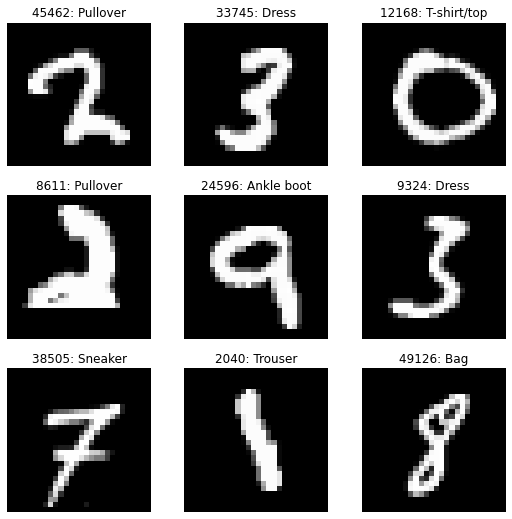

In [8]:
# Here, we show 9 random images, their indices, and labels. 

fig,ax=plt.subplots(3,3,figsize=(9,9))

for k in range(9):
    n = random.randint(0,len(train_dataset))
    x,y = train_dataset[n]
    i,j = k%3, int(k/3)
    ax[i][j].imshow(x[0],cmap="gray")
    ax[i][j].set_title("%d: %s" % (n,meanings[y]));
    ax[i][j].axis('off');

In [9]:
ZDIM = 50
CHA = 8
CHB = 16

class VAE(nn.Module):
    def __init__(self):

        super(VAE, self).__init__()
        
        # Encoder
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, CHA, kernel_size=5, padding=2),
            nn.BatchNorm2d(CHA),
            nn.ReLU()) 
        self.layer2 = nn.Sequential(
            nn.Conv2d(CHA, CHB, kernel_size=5, padding=2),
            nn.BatchNorm2d(CHB),
            nn.ReLU()) 
        self.compress = nn.Linear(28*28*CHB, 100)
        self.fc1 = nn.Linear(100, ZDIM) # for mu
        self.fc2 = nn.Linear(100, ZDIM) # for logvar

        # Decoder
        self.expand1 = nn.Linear(ZDIM, 100)
        self.expand2 = nn.Linear(100, 28*28*CHB)
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(CHB,CHA, kernel_size=5, padding=2), 
            nn.BatchNorm2d(CHA),
            nn.ReLU()
        )    
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(CHA,1, kernel_size=5, padding=2), 
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
        self.sigmoid = nn.Sigmoid()

    def reparameterize(self,mu,logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu        
        
    def encode(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.compress(out)
        r1 = self.fc1(out)
        r2 = self.fc2(out)
        return r1, r2
    
    def decode(self, z):
        out = self.expand1(z)   # ZDIM ==> 100
        out = self.expand2(out) # 100 ==> 28*28*CHB
        out = out.view(-1,CHB,28,28)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.sigmoid(out)
        return out    
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar  
    

ZDIM = 20
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, ZDIM)
        self.fc22 = nn.Linear(400, ZDIM)
        self.fc3 = nn.Linear(ZDIM, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h3 = torch.sigmoid(self.fc4(h3))
        h3 = h3.reshape(-1,1,28,28)
        return h3

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        # loss1 = self.mse_loss(x_recon, x)
        loss1 = F.binary_cross_entropy(x_recon.view(-1, 784), x.view(-1, 784), reduction='sum')
        loss2 = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return ( loss1 + loss2 ) 

torch.Size([2, 1, 28, 28])

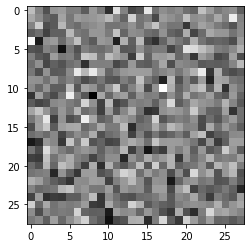

In [11]:
batch_size = 2

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True);

images, _ = next(iter(train_loader))
images = Variable(images.float()) / 255

vae = VAE()
new_images,mu,lv = vae(images)
plt.imshow(new_images.detach()[0][0], cmap="gray")
new_images.shape

In [ ]:
batch_size = 128
num_epochs = 15

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True);

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
loss_fcn = customLoss()

losses = []
for i in range(num_epochs):
    for images, _ in train_loader:
        images = Variable(images.float()) / 255
        optimizer.zero_grad()
        outputs, mu, logvar = vae(images)
        loss = loss_fcn(outputs, images, mu, logvar)
        loss.backward()
        optimizer.step()
        losses.append(loss) 
        sys.stdout.write("\r%d: %lf    " % (i,loss))


0: 27429.802734    

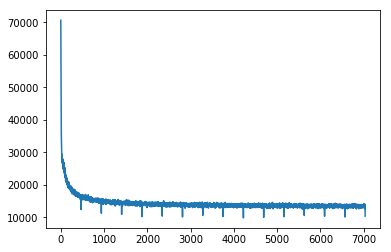

In [374]:
plt.plot(losses);

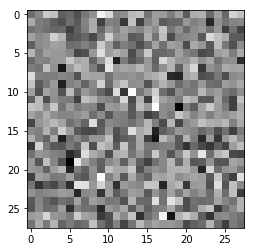

In [382]:
batch_size = 2

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True);

images, _ = next(iter(train_loader)) 
images = Variable(images.float()) / 255

vae = VAE()
vae.eval();
new_images, _, _ = vae(images)
plt.imshow(new_images.detach()[0][0], cmap="gray");